In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 2, 2, 3
original_img_size = (img_rows, img_cols, img_chns)
samples = 1

batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 1))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 1))

# Generate a dataset based on mixtures of logistic

In [3]:
np.random.seed(0)

# logistic std deviation of 1 pixel level
unit_s = 1 / math.pi * math.sqrt(3)

def train_data_simple(samples):
    # Each pixel is a independent single logstic
    X_train = np.zeros((1, img_rows, img_cols, img_chns))
    for n in range(samples):
        for i in range(img_rows):
            for j in range(img_cols):
                for k in range(img_chns):
                    m = np.random.normal(127, 80, 1)
                    s = np.random.uniform(1 * unit_s, 40 * unit_s, 1)
                    pixel = int(np.random.logistic(m, s, 1))
                    #print(m, s, int(255.*max(min(pixel, 1.0), 0.)))
                    X_train[n, i, j, k] = max(min(pixel, 255), 0)
                    
    return X_train

X_train = train_data_simple(samples)
X_train = (X_train - 127.5)/ 127.5
print(X_train.shape)
X_train

(1, 2, 2, 3)


array([[[[ 1.        ,  0.28627451,  0.50588235],
         [-0.09019608,  0.42745098,  0.08235294]],

        [[ 0.50588235,  0.30196078,  0.27058824],
         [-0.57647059,  0.56078431, -0.46666667]]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


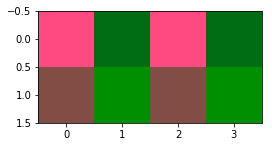

In [4]:
n = min(samples, 10)
figure = np.zeros((img_rows * n, img_cols * 2, img_chns))
for i in range(n):
    orig_img = X_train[i] 
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = orig_img
    
    # Digitize
    img = (orig_img * 255.).astype(float) / 255
    figure[dy:dy + img_rows, img_cols:2 * img_cols] = img

plt.figure(figsize=(n * 4, 10))
plt.imshow(figure)
plt.show()

# Pixel CNN Helpers

# Model

In [5]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1

In [6]:
def pixelcnn_loss(target, output):
    output_m = output[:, :, :, :3]
    output_invs = output[:, :, :, 3:]
    
    x = K.reshape(target, (-1, img_rows, img_cols, img_chns * mixture_components))
    
    #x_decoded_m = K.batch_flatten(output_m)
    #x_decoded_invs = K.batch_flatten(output_invs)
    #x_weights = K.batch_flatten(output_mixture)
    x_decoded_m = output_m
    x_decoded_invs = output_invs
   
    offset = 1. / 255. / 2.
    centered_mean = x - x_decoded_m
    cdfminus_arg = (centered_mean - offset) * K.exp(x_decoded_invs)
    cdfplus_arg = (centered_mean + offset) * K.exp(x_decoded_invs)
                   
    cdfminus_safe = K.sigmoid(cdfminus_arg)
    cdfplus_safe = K.sigmoid(cdfplus_arg)
  
    # ln (sigmoid(x)) = x - ln(e^x + 1) = x - softplus(x)
    log_cdfplus = cdfplus_arg - K.tf.nn.softplus(cdfplus_arg)
    log_1minus_cdf = -K.tf.nn.softplus(cdfminus_arg)
    log_ll = K.tf.where(x <= 0.001, log_cdfplus,
                        K.tf.where(x >= 0.999, log_1minus_cdf,
                                   K.log(K.maximum(cdfplus_safe - cdfminus_safe, 1e-10))))
    
    
    #log_ll = K.log(K.maximum(cdfplus_safe - cdfminus_safe, 1e-10))
    #log_ll = K.log(cdfplus_safe - cdfminus_safe + 1e-10)
    return -K.sum(K.batch_flatten(log_ll), axis=-1)
    
    ## x_weights * [sigma(x+0.5...) - sigma(x-0.5 ...) ]
    ## = log x_weights + log (...)
    #pre_result = K.log(x_weights) + log_ll
    #
    #result = []
    #for chn in range(img_chns):
    #    chn_result = pre_result[:, :, :, chn*mixture_components:(chn+1)*mixture_components]
    #    v = K.logsumexp(chn_result, axis=-1)
    #    result.append(v)
    #result = K.batch_flatten(K.stack(result, axis=-1))
    #return -K.sum(result, axis=-1)

In [7]:
from keras.initializers import RandomUniform
main_input = Input(shape=original_img_size, name='main_input')

ms = []
invss = []
for channel in range(img_chns):
    x = Lambda(lambda x: x * 0.)(main_input)
    x = Flatten()(x)
    decoder_out_m_ = Dense(img_rows * img_cols, name='x_m' + str(channel))(x)
    decoder_out_m_ = Lambda(lambda x: x + 0.5)(decoder_out_m_)
    decoder_out_m = Reshape((img_rows, img_cols, 1))(decoder_out_m_)
    ms.append(decoder_out_m)
    
    decoder_out_invs_ = Dense(img_rows * img_cols, name='x_s' + str(channel), activation='hard_sigmoid')(x)
    decoder_out_invs = Lambda(lambda x: 7. * x)(decoder_out_invs_)
    decoder_out_invs = Reshape((img_rows, img_cols, 1))(decoder_out_invs)
    #decoder_out_invs_ = Dense(img_rows * img_cols, name='x_s' + str(channel), activation='relu')(x)
    #decoder_out_invs = Lambda(lambda x: x)(decoder_out_invs_)
    #decoder_out_invs = Reshape((img_rows, img_cols, 1))(decoder_out_invs)
    invss.append(decoder_out_invs)

out_m = Concatenate()(ms)
out_invs = Concatenate()(invss)
main_output = Concatenate()([out_m, out_invs])

In [8]:
print("Building model...")
#optimizer = RMSprop(lr=0.001)
optimizer = SGD(lr=0.001)
model = Model(inputs=main_input, outputs=main_output)
model.compile(optimizer=optimizer, loss=pixelcnn_loss)
model.summary()

Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 2, 3)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
___________________________________________________________________________________________

In [17]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs/1x5_7elu_p2_sgd', histogram_freq=1, batch_size=1, write_graph=True, 
                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=200,
    callbacks=[TQDMNotebookCallback(), tensorboard],#, early_stopping, reduce_lr],
    validation_data=(X_train, X_train),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  12.73274564743042


,val_loss,loss
count,200.000000,200.000000
mean,38.202543,38.218031
std,0.861099,0.865747
min,36.919273,36.929646
0%,36.919273,36.929646
25%,37.462251,37.473839
50%,38.087692,38.101528
75%,38.872567,38.890920
95%,39.725381,39.750754
99%,39.934203,39.961611


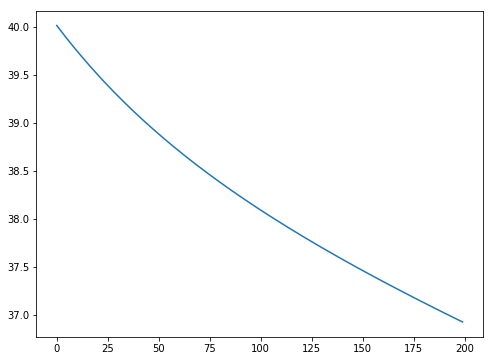

In [18]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [11]:
lossvals = model.evaluate(X_train, X_train)
print(lossvals)

1/1 [==============================] - 0s 4ms/step
40.016868591308594


In [12]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def compute_pvals(m, invs):
    # TODO FIX ME when adding more mixtures
    pvals = []
    for i in range(256):
        if i == 0:
            pval = logistic.cdf(0.5 / 255., loc=m, scale=1. / np.exp(invs))
        elif i == 255:
            pval = 1. - logistic.cdf(254.5 / 255., loc=m, scale=1. / np.exp(invs))
        else:
            pval = (logistic.cdf(i / 255. + 0.5 / 255., loc=m, scale=1. / np.exp(invs))
                    - logistic.cdf(i / 255. - 0.5 / 255., loc=m, scale=1. / np.exp(invs)))
        pvals.append(pval)
    
    return pvals

def compute_mixture(ms, invs, weights):
    components = []
    for i in range(mixture_components):
        components.append(weights[i] * np.array(compute_pvals(ms[i], invs[i])))
    return np.sum(components, axis=0)

(2, 4, 3)


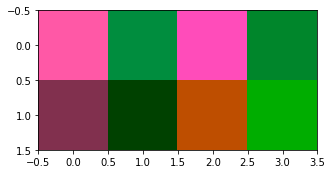

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


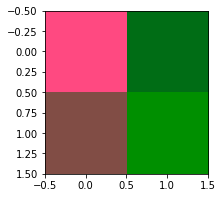

Elapsed:  1.4188499450683594


In [13]:
debug = False

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    #x_sample[0, :, :, :] = X_train[0, :, :, :]
    #x_sample[0, 0, 0, 0] = X_train[0, 0, 0, 0]
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    x_ms = x_out[n, i, j, k:k+1]
                    x_invs = x_out[n, i, j, 3+k:3+k+1]
                    pvals = np.array(compute_pvals(x_ms, x_invs)).reshape(-1)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val / 255.
                    if (i < 5 or 15 <= i <=17) and (j < 5 or 15 <= j <= 17) and debug:
                        actual = int(X_train[0, i, j, k] * 255.)
                        if abs(pixel_val - actual) > 50:
                            print("====", i, j, k)
                            print(" m: ", x_ms)
                            print(" invs: ", x_invs)
                            print(" mean_val: ", int(x_ms*255.), " +/-", 255./np.exp(x_invs) * math.pi / math.sqrt(3))
                            print(" pixel_val: ", pixel_val)
                            print(" actual: ", actual)
                            #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                            #print(" x_out: ", x_out)
                            #print(" sample_val: ", x_sample[n, i, j, k])
                            l = max(actual-10,0)
                            r = min(actual+10, 256)
                            ps = zip(range(l, r), pvals[l:r])
                            for index, val in ps:
                                print(index, ":", val)
        if debug:
            print("row", i)
                
    return x_sample


start = time.time()

n = 1 if debug else 2
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * n, img_chns))
print(figure.shape)
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(5, 5))
plt.imshow(figure)
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(orig_img)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

# Notes

### 2019-02-25

* Interesting: At the output of the mean pixels I add the `0.5` to `lambda x:
  4. * x + 0.5` and it converges so much faster!  Any value between (0.4-0.7)
  seems to work.  It must be the case that the extra constant helps "kickstart"
  the momentum because the bias is initalized to 0?  Not quite sure why it's so
  much faster.

### 2019-02-28

* Setup:
    * Just have simple biases hooked up to each m, s
    * Played around with activation function, range of activations and optimizer
* Did some debugging with Tensorboard:
    * A lot of the difference in convergence with changing the optimizer, SGD
      seems to converge fastest, probably because momentum isn't slowing things 
      down
    * The "0.5" effect I think is probably because of the fact that biases start at 0.
    * It looks like my guess of having std. dev scaled to 0 to 7 is pretty good
      b/c 3.5 seems like a good "default".  3.5 translates to about 14 pixel
      std deviation ( 1 / exp(3.5) * pi / sqrt(3) -- logistic distribution)
    * There's some subtle interplay between m and s.  m seems to often get to the
      best values (in terms of distribution) but s seems to have a hard to
      optimizing for the ideal.
* It looks like things converge fastest with: m = b + 0.5, s=7*hard_sigmoid(b) where b is just the bias parameter from the network
